# Part 0: Set up google drive environment

In [1]:
# install pydrive to load data
!pip install -U -q PyDrive

In [2]:
pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [4]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
id = "1konOLheBhUiLfDK67L1WtANCYyS5thB8"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('vehicles.csv')

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import urllib
import requests

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# Data Pre-processing

In [11]:
valid_part = 0.3
# pd.set_option('max_columns',50)

In [12]:
vehicle_df = pd.read_csv('vehicles.csv')
vehicle_df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [13]:
drop_columns = ['id','url', 'region', 'region_url', 'VIN', 'description', 'county','image_url', 'lat','long', 'posting_date']
# drop_columns = ['id','url', 'region', 'region_url', 'VIN', 'description', 'county','image_url', 'lat','long', 'posting_date', 'model']
## dropped model
vehicle_df = vehicle_df.drop(columns = drop_columns)
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


In [14]:
# year range (1960, 2021)
vehicle_df.drop(vehicle_df[vehicle_df.year < 1960].index, inplace = True)
vehicle_df.drop(vehicle_df[vehicle_df.year > 2021].index, inplace = True)

# price range (100, 100,000)
vehicle_df.drop(vehicle_df[vehicle_df.price < 100].index, inplace = True)
vehicle_df.drop(vehicle_df[vehicle_df.price > 100000].index, inplace = True)

# delete missing vals
vehicle_df = vehicle_df.dropna(axis = 0, subset = ['year', 'manufacturer', 'model', 'fuel', 'odometer', 'transmission'])
# vehicle_df = vehicle_df.dropna(axis = 0, subset = ['year', 'manufacturer', 'fuel', 'odometer', 'transmission'])

# imputate with mode
vehicle_df['title_status'].fillna(vehicle_df['title_status'].mode()[0], inplace = True)
vehicle_df['drive'].fillna(vehicle_df['drive'].mode()[0], inplace = True)
vehicle_df['size'].fillna(vehicle_df['size'].mode()[0], inplace = True)
vehicle_df['type'].fillna(vehicle_df['type'].mode()[0], inplace = True)
vehicle_df['paint_color'].fillna(vehicle_df['paint_color'].mode()[0], inplace = True)
vehicle_df['condition'].fillna(vehicle_df['condition'].mode()[0], inplace = True)
vehicle_df['cylinders'].fillna(vehicle_df['cylinders'].mode()[0], inplace = True)

vehicle_df['odometer'] = (vehicle_df['odometer']).astype(int)
vehicle_df.drop_duplicates(inplace = True, ignore_index = True)

In [ ]:
vehicle_df.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

## Add Climate feature

In [15]:
us_state_to_abbrev = {
"Alabama": "AL",
"Alaska": "AK",
"Arizona": "AZ",
"Arkansas": "AR",
"California": "CA",
"Colorado": "CO",
"Connecticut": "CT",
"Delaware": "DE",
"Florida": "FL",
"Georgia": "GA",
"Hawaii": "HI",
"Idaho": "ID",
"Illinois": "IL",
"Indiana": "IN",
"Iowa": "IA",
"Kansas": "KS",
"Kentucky": "KY",
"Louisiana": "LA",
"Maine": "ME",
"Maryland": "MD",
"Massachusetts": "MA",
"Michigan": "MI",
"Minnesota": "MN",
"Mississippi": "MS",
"Missouri": "MO",
"Montana": "MT",
"Nebraska": "NE",
"Nevada": "NV",
"New Hampshire": "NH",
"New Jersey": "NJ",
"New Mexico": "NM",
"New York": "NY",
"North Carolina": "NC",
"North Dakota": "ND",
"Ohio": "OH",
"Oklahoma": "OK",
"Oregon": "OR",
"Pennsylvania": "PA",
"Rhode Island": "RI",
"South Carolina": "SC",
"South Dakota": "SD",
"Tennessee": "TN",
"Texas": "TX",
"Utah": "UT",
"Vermont": "VT",
"Virginia": "VA",
"Washington": "WA",
"West Virginia": "WV",
"Wisconsin": "WI",
"Wyoming": "WY",
"District of Columbia": "DC",
"American Samoa": "AS",
"Guam": "GU",
"Northern Mariana Islands": "MP",
"Puerto Rico": "PR",
"United States Minor Outlying Islands": "UM",
"U.S. Virgin Islands": "VI"
}

In [16]:
## extract data from 1960 to 2021 through Jan to Dec
temperatureData = None
for i in range(1, 13):  # for each month in the same state
  print("Processing Month number: " + str(i))
  for j in range(1, 53):   # for each states in US
    link = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/"+ str(j) +"/tavg/1/" + str(i) + "/1960-2021.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000"
    ret = requests.get(link).status_code
    if (ret != 200):
      continue
    else:
    # link = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/2/tavg/1/12/1960-2021.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000"
    # # f = urllib.request.urlopen(link)
      tempfile = pd.read_csv(link)
      state = tempfile.columns.tolist()[0]
      state_abbrev = us_state_to_abbrev[state].lower()
      month = tempfile.columns.tolist()[2].lstrip()
      tempfile.columns = ["Date", "Temperature", "Anomaly"]
      state_data = tempfile[4:]
      state_data['Month'] = month
      state_data['State'] = state 
      state_data['State_abbrev'] = state_abbrev
      state_data['Year'] = state_data['Date'].str[0:4]
      temperatureData = pd.concat([temperatureData, state_data])


Processing Month number: 1
Processing Month number: 2
Processing Month number: 3
Processing Month number: 4
Processing Month number: 5
Processing Month number: 6
Processing Month number: 7
Processing Month number: 8
Processing Month number: 9
Processing Month number: 10
Processing Month number: 11
Processing Month number: 12


In [17]:
temperatureData

,Date,Temperature,Anomaly,Month,State,State_abbrev,Year
4,196001,44.5,-0.6,January,Alabama,al,1960
5,196101,39.2,-5.9,January,Alabama,al,1961
6,196201,42.6,-2.5,January,Alabama,al,1962
7,196301,39.1,-6.0,January,Alabama,al,1963
8,196401,42.4,-2.7,January,Alabama,al,1964
...,...,...,...,...,...,...,...
61,201712,19.1,15.4,December,Alaska,ak,2017
62,201812,9.1,5.4,December,Alaska,ak,2018
63,201912,6.7,3.0,December,Alaska,ak,2019
64,202012,10.6,6.9,December,Alaska,ak,2020


In [18]:
all_states = vehicle_df['state'].unique().tolist()

In [19]:
np.intersect1d(vehicle_df['state'].unique(), temperatureData['State_abbrev'].unique())

array(['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'ia',
       'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn',
       'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny',
       'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va',
       'vt', 'wa', 'wi', 'wv', 'wy'], dtype=object)

In [20]:
set(vehicle_df['state'].unique())^set(temperatureData['State_abbrev'].unique())

{'dc', 'hi'}

NCEI didn't record temperature information for state DC and HI.

In [21]:
temperatureData = temperatureData.astype({'Temperature': 'float', 'Anomaly': 'float'})

In [22]:
temperatureData.dtypes

Date             object
Temperature     float64
Anomaly         float64
Month            object
State            object
State_abbrev     object
Year             object
dtype: object

In [26]:
## use Jan and Jul temperature info to define cold, temperate and warm states
month_summary = temperatureData.groupby(['Month','State_abbrev'])['Temperature'].mean().reset_index(name ='Avg_temperature').round(1)
temp_month = ['January', 'July']
sel_month_summary = month_summary [month_summary .Month.isin(temp_month)]
## select cold state
c1 = sel_month_summary[(sel_month_summary.Avg_temperature <= 26.6) & (sel_month_summary.Month == 'January')]['State_abbrev']
c2 = sel_month_summary[(sel_month_summary.Avg_temperature <= 64.4) & (sel_month_summary.Month == 'July')]['State_abbrev']
## select warm state
w1 = sel_month_summary[(sel_month_summary.Avg_temperature >= 55.4) & (sel_month_summary.Month == 'January')]['State_abbrev']
w2 = sel_month_summary[(sel_month_summary.Avg_temperature >= 80.6) & (sel_month_summary.Month == 'July')]['State_abbrev']

In [27]:
warm_states = list(set(w1) | set(w2))
warm_states.append('hi')
cold_states = list(set(c1) | set(c2))
temperate_states = list(set(all_states)^(set(warm_states) | set(cold_states)))

Add temperature info to the dataset

In [31]:
vehicle_df.loc[vehicle_df['state'].isin(warm_states), 'Climate'] = 'Warm' 
vehicle_df.loc[vehicle_df['state'].isin(cold_states), 'Climate'] = 'Cold'
vehicle_df.loc[vehicle_df['state'].isin(temperate_states), 'Climate'] = "Temperate"

# Exploratory Data Analysis (EDA) using pandas profiling

In [32]:
vehicle_df['price'].value_counts()

4500     2282
3500     2183
6995     2120
5500     2119
6500     2079
         ... 
27168       1
4372        1
14693       1
20753       1
19853       1
Name: price, Length: 14879, dtype: int64

In [33]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256298 entries, 0 to 256297
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         256298 non-null  int64  
 1   year          256298 non-null  float64
 2   manufacturer  256298 non-null  object 
 3   model         256298 non-null  object 
 4   condition     256298 non-null  object 
 5   cylinders     256298 non-null  object 
 6   fuel          256298 non-null  object 
 7   odometer      256298 non-null  int64  
 8   title_status  256298 non-null  object 
 9   transmission  256298 non-null  object 
 10  drive         256298 non-null  object 
 11  size          256298 non-null  object 
 12  type          256298 non-null  object 
 13  paint_color   256298 non-null  object 
 14  state         256298 non-null  object 
 15  Climate       256298 non-null  object 
dtypes: float64(1), int64(2), object(13)
memory usage: 31.3+ MB


In [34]:
vehicle_df.describe()

,price,year,odometer
count,256298.000000,256298.000000,2.562980e+05
mean,17516.061460,2010.901860,1.016355e+05
std,13986.229062,8.287119,1.770696e+05
min,100.000000,1960.000000,0.000000e+00
25%,6850.000000,2007.000000,4.246000e+04
50%,13987.000000,2013.000000,9.300000e+04
75%,25000.000000,2017.000000,1.400000e+05
max,100000.000000,2021.000000,1.000000e+07


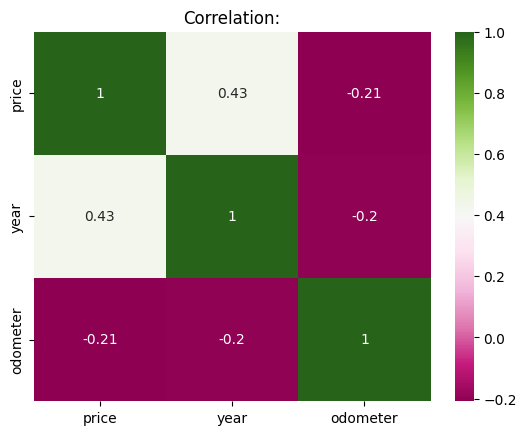

In [35]:
sns.heatmap(vehicle_df.corr(), annot = True, cmap="PiYG")
plt.title("Correlation:")
plt.show() # price related categorical variables includes year, odometer, and age

In [ ]:
pp.ProfileReport(vehicle_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Preparing data

In [36]:
target = 'price'
y = vehicle_df[target]   # equals to y
X = vehicle_df.drop([target], axis = 1) # equals to X

In [37]:
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')].tolist()
cat_cols = X.columns[X.dtypes == 'O'].tolist()

ordinal_cols = ['condition']
label_cols = ['state', 'manufacturer', 'model']
# label_cols = ['state', 'manufacturer']
onehot_cols = [ele for ele in cat_cols if ele not in ordinal_cols]
onehot_cols = [ele for ele in onehot_cols if ele not in label_cols]

In [38]:
train0, test0, train_target0, test_target0 = train_test_split(X, y, test_size = .2, random_state = 0)

print('training data has ' + str(train0.shape[0]) + ' observation with ' + str(train0.shape[1]) + ' features')
print('test data has ' + str(test0.shape[0]) + ' observation with ' + str(test0.shape[1]) + ' features')

training data has 205038 observation with 15 features
test data has 51260 observation with 15 features


In [39]:
# boosting
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models (how to use this part)
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size = valid_part, random_state = 0)

In [40]:
## categorical features encoding
## label encoding
categorical_cols = label_cols

for col in categorical_cols:
  print(col)
  enc_le = LabelEncoder()
  # enc_le.fit(train0[col])
  enc_le.fit(X[col])
  train0[col] =  enc_le.transform(train0[col])
  test0[col] =  enc_le.transform(test0[col])

  trainb[col] =  enc_le.transform(trainb[col])
  testb[col] =  enc_le.transform(testb[col])

# for col in categorical_cols:
#   label_encoder = LabelEncoder()
#   label_encoder.fit(list(train0[col].astype(str).values))
#   train0[col] = label_encoder.transform(list(train0[col].astype(str).values))
#   test0[col] = label_encoder.transform(list(test0[col].astype(str).values))

state
manufacturer
model


In [41]:
## Ordinal encoding
categories = ['condition', 'Climate']

for col in categorical_cols:
  col = [col]
  enc_oe = OrdinalEncoder()
  enc_oe.fit(train0[categories])
  train0[categories] =  enc_oe.transform(train0[categories])
  test0[categories] =  enc_oe.transform(test0[categories])

  enc_oe.fit(trainb[categories])
  trainb[categories] =  enc_oe.transform(trainb[categories])
  testb[categories] =  enc_oe.transform(testb[categories])


In [42]:
onehot_cols

['cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'Climate']

In [43]:
## One hot encoding
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = onehot_cols
for col in categories:
  col = [col]
  enc_ohe = OneHotEncoder()
  enc_ohe.fit(train0[col])
  train0 = OneHotEncoding(train0, enc_ohe, col)
  test0 = OneHotEncoding(test0, enc_ohe, col)

  enc_ohe.fit(trainb[col])
  trainb = OneHotEncoding(trainb, enc_ohe, col)
  testb = OneHotEncoding(testb, enc_ohe, col)




In [44]:
train0

,year,manufacturer,model,condition,odometer,state,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,...,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,Climate_0.0,Climate_1.0,Climate_2.0
0,2013.0,13,8996,2.0,148444,48,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2013.0,21,14022,0.0,144272,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2018.0,6,21121,2.0,77596,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2011.0,13,7081,0.0,97347,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2019.0,16,13929,2.0,72230,31,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205033,2016.0,7,17852,2.0,70919,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
205034,2014.0,17,7287,2.0,44043,19,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
205035,2011.0,30,2975,2.0,151802,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
205036,1970.0,7,4160,2.0,20000,5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
test0

,year,manufacturer,model,condition,odometer,state,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,...,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,Climate_0.0,Climate_1.0,Climate_2.0
0,1997.0,36,14052,2.0,144585,26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2011.0,7,5831,2.0,30237,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2006.0,33,644,0.0,169953,12,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2007.0,38,14644,3.0,64950,38,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1997.0,38,18496,2.0,245000,47,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51255,2012.0,7,6077,2.0,94749,38,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51256,2017.0,20,20484,3.0,60840,36,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51257,2013.0,10,10982,2.0,164329,23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
51258,1976.0,13,12989,2.0,78000,5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Feature Standardize/Normalization

In [46]:
# feature standardization based on mean and sd
scaler = StandardScaler()
scaler.fit(train0[num_cols])
train0[num_cols] = scaler.transform(train0[num_cols])
test0[num_cols] = scaler.transform(test0[num_cols])

scaler.fit(trainb[num_cols])
trainb[num_cols] = scaler.transform(trainb[num_cols])
testb[num_cols] = scaler.transform(testb[num_cols])

In [47]:
train0

,year,manufacturer,model,condition,odometer,state,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,...,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,Climate_0.0,Climate_1.0,Climate_2.0
0,0.253820,13,8996,2.0,0.259272,48,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.253820,21,14022,0.0,0.236121,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.856847,6,21121,2.0,-0.133872,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.012609,13,7081,0.0,-0.024271,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.977452,16,13929,2.0,-0.163648,31,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205033,0.615636,7,17852,2.0,-0.170923,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
205034,0.374425,17,7287,2.0,-0.320061,19,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
205035,0.012609,30,2975,2.0,0.277905,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
205036,-4.932213,7,4160,2.0,-0.453478,5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
# test for selection models
# train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)
train, test, target, target_test = train0, test0, train_target0, test_target0

In [49]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [50]:
def acc_d(y_meas, y_pred):
    # Relative error b/w predicted y_pred & measured y_meas 
    return mean_absolute_error(y_meas, y_pred) * len(y_meas) / sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted & meas vals
    return (mean_squared_error(y_meas, y_pred)) ** .5

In [51]:
def acc_model(num, model, train, test, num_iteration=0):
    # Accuracy of models using different metrics
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse

    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for training = ', acc_train_r2_num)
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for training =', acc_train_d_num)
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for training =', acc_train_rmse_num)
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])

    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)


# Tuning models & test for all features


## Linear Regression

In [53]:
lin_reg = LinearRegression()
lin_reg.fit(train, target)
acc_model(0, lin_reg, train, test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [34884.87244972 12607.22771141 30341.07451375 24842.29725629
 26401.08637815]
acc(r2_score) for training =  44.51
acc(relative error) for training = 41.11
acc(rmse) for training = 1041393.73
target_test = [ 4000 38590 11995  6999  6500]
ytest = [ 8405.46359852 29313.9973466  20873.67817558  6346.79548085
 12643.2157316 ]
acc(r2_score) for test = 44.79
acc(relative error) for test = 41.22
acc(rmse) for test = 1040912.62


## Linear SVR

In [54]:
linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2, linear_svr, train, test)

target =  [29999  6850 23590 13900 26985]
ytrain =  [22931.91619817 13137.72757903 25943.33177516 16616.45070259
 24045.44347903]
acc(r2_score) for training =  33.74
acc(relative error) for training = 42.6
acc(rmse) for training = 1137967.45
target_test = [ 4000 38590 11995  6999  6500]
ytest = [10015.19023724 22218.49553211 14019.07574281 10056.00542667
 11144.63631493]
acc(r2_score) for test = 34.83
acc(relative error) for test = 42.7
acc(rmse) for test = 1130997.38


## Support Vector Machines (SVM)

In [ ]:
svr = SVR()
svr.fit(train, target)
acc_model(1, svr, train, test)

## MLP Regressor

In [ ]:
mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
target =  [ 6995  1028  9800 11990 46990]
ytrain =  [12096.75536008 37701.46880073  8028.83733259  9015.72742153
 43199.44512663]
acc(r2_score) for training =  67.08
acc(relative error) for training = 29.53
acc(rmse) for training = 806968.29
target_test = [64468 34590 13995 72999  5000]
ytest = [34094.77794469 34170.21443621 10321.15142377 60048.76502833
  5807.76784492]
acc(r2_score) for test = 66.42
acc(relative error) for test = 29.59
acc(rmse) for test = 816444.54


## Stochastic Gradient Descent

In [ ]:
sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4, sgd, train, test)

target =  [ 6995  1028  9800 11990 46990]
ytrain =  [1.71056706e+15 6.75419309e+14 1.59646536e+15 6.95450951e+14
 1.76252433e+15]
acc(r2_score) for training =  -6.428185515657827e+23
acc(relative error) for training = 5637125076127.48
acc(rmse) for training = 1.127687948262479e+17
target_test = [64468 34590 13995 72999  5000]
ytest = [7.14488954e+14 1.76753197e+15 1.31532590e+15 1.55196702e+15
 3.77280961e+14]
acc(r2_score) for test = -6.357383068667354e+23
acc(relative error) for test = 5607696593865.1
acc(rmse) for test = 1.1234054507731506e+17


## Decision Tree Regressor

In [ ]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [ 6995  1028  9800 11990 46990]
ytrain =  [ 6995.  1028.  9800. 11990. 46990.]
acc(r2_score) for training =  99.93
acc(relative error) for training = 0.11
acc(rmse) for training = 37744.74
target_test = [64468 34590 13995 72999  5000]
ytest = [64999. 34590.  9800. 72665.  4900.]
acc(r2_score) for test = 68.56
acc(relative error) for test = 22.11
acc(rmse) for test = 790043.94


## Random Forest

In [ ]:
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
print(get_params(random_forest))
acc_model(6,random_forest,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [15360.48       47335.11888889 11724.5        27341.29
  1842.775     ]
acc(r2_score) for training =  98.26
acc(relative error) for training = 4.65
acc(rmse) for training = 189998.59
target_test = [24995  5995 14990 36900  6900]
ytest = [25607.02 12023.42 14909.65 52516.27  8284.23]
acc(r2_score) for test = 88.06
acc(relative error) for test = 12.27
acc(rmse) for test = 498276.16


In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
# parameters = {
#     'n_estimators' : [60,80,100],
#     'max_depth': [1,5,10]
# }
# random_forest = GridSearchCV(RandomForestRegressor(random_state=41),parameters, cv=5)
# random_forest.fit(train, target)
# acc_model(6,random_forest,train,test)

target =  [ 7000 14995  3800 28163  2700]
ytrain =  [ 5590.84046908 16259.37642857  7475.49777778 28623.68
  3389.14380519]
acc(r2_score) for training =  97.53
acc(relative error) for training = 6.72
acc(rmse) for training = 222481.9
target_test = [56999  9995 19477   665 11490]
ytest = [22000.21622222  9776.65428571 22868.38688413 22076.03333333
 10035.03222222]
acc(r2_score) for test = 82.68
acc(relative error) for test = 17.64
acc(rmse) for test = 590764.22


In [ ]:
# best_RF_model = random_forest.best_estimator_
# best_RF_model = random_forest.best_score_

## XGB

In [ ]:
xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')  # {'objective': 'reg:squarederror'}
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_model(7,xgb_reg,trainb,testb)

Best score: 0.828
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}
target =  [14995 47900 11500 32500  1750]
ytrain =  [15374.749 51056.48  11966.418 19825.652  2853.787]
acc(r2_score) for train = 84.89
acc(relative error) for train = 18.04
acc(rmse) for train = 559385.2
target_test = [24995  5995 14990 36900  6900]
ytest = [27438.225 14180.932 11321.013 47157.13   7673.058]
acc(r2_score) for test = 83.23
acc(relative error) for test = 18.73
acc(rmse) for test = 590597.46


## Light GBM

In [ ]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9978
[LightGBM] [Info] Number of data points in the train set: 172137, number of used features: 14
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 18794.093280
Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 7304.01
[1000]	valid_0's rmse: 6742.9
[1500]	valid_0's rmse: 6469.04
[2000]	valid_0's rmse: 6279.22
[2500]	valid_0's rmse: 6136.12
[3000]	valid_0's rmse: 6020.85


In [ ]:
acc_model(8,modelL,trainb,testb,modelL.best_iteration)

target =  [14995 47900 11500 32500  1750]
ytrain =  [13656.05845062 50538.07104722 11055.71036117 18365.5739292
  2390.22950121]
acc(r2_score) for train = 89.63
acc(relative error) for train = 14.66
acc(rmse) for train = 463434.9
target_test = [24995  5995 14990 36900  6900]
ytest = [26734.13237912 13186.73338038 11485.16846963 46704.78227195
  6892.88514201]
acc(r2_score) for test = 87.23
acc(relative error) for test = 15.75
acc(rmse) for test = 515252.4


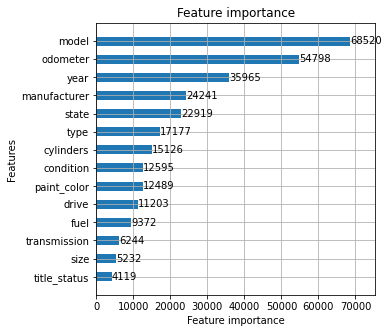

In [ ]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

## Ridge Regression

In [ ]:
ridge = RidgeCV(cv = 5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [19160.6089971  29427.98996055 16467.98247551 19955.10808726
 14533.13267113]
acc(r2_score) for training =  28.83
acc(relative error) for training = 47.34
acc(rmse) for training = 1213935.09
target_test = [24995  5995 14990 36900  6900]
ytest = [19065.8987924  22162.09649665 24755.40891055 20958.35642968
  6920.84606344]
acc(r2_score) for test = 29.46
acc(relative error) for test = 47.22
acc(rmse) for test = 1211198.84


## Bagging Regressor

In [ ]:
bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [15995.   47904.3  12206.9  26246.5   2603.75]
acc(r2_score) for training =  97.52
acc(relative error) for training = 5.36
acc(rmse) for training = 226730.47
target_test = [24995  5995 14990 36900  6900]
ytest = [24280.7 15826.2 14990.  47447.6  8382. ]
acc(r2_score) for test = 86.66
acc(relative error) for test = 13.26
acc(rmse) for test = 526702.52


## Extra Trees Regressor

In [ ]:
# etr = ExtraTreesRegressor()
parameters = {
    'n_estimators' : [60,80,100,500],
    'max_depth': [1,5,10]
}
etr = GridSearchCV(ExtraTreesRegressor(random_state=41),parameters, cv=5)
etr.fit(train, target)
acc_model(12,etr,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [14995. 47900. 11500. 32500.  1675.]
acc(r2_score) for training =  99.95
acc(relative error) for training = 0.1
acc(rmse) for training = 31906.05
target_test = [24995  5995 14990 36900  6900]
ytest = [24995.         11125.85       14990.         45381.39333333
  7358.48      ]
acc(r2_score) for test = 88.71
acc(relative error) for test = 11.0
acc(rmse) for test = 484628.54


## Voting Regressor

In [ ]:
# Voting_Reg = VotingRegressor(estimators=[('lin', lin_reg), ('ridge', ridge), ('sgd', sgd)])
Voting_Reg = VotingRegressor(estimators=[('etr', etr), ('random_forest', random_forest)])
params = {'weights': [(1,1), (1,2),(1,5),(2,1)]}

GridSearchCV(Voting_Reg, params)
Voting_Reg.fit(train, target)
acc_model(14,Voting_Reg,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [15306.675  47723.01   11635.685  29862.06    1793.3325]
acc(r2_score) for training =  99.53
acc(relative error) for training = 2.38
acc(rmse) for training = 99014.03
target_test = [24995  5995 14990 36900  6900]
ytest = [25694.74   12009.83   14947.545  48196.85    7885.3475]
acc(r2_score) for test = 89.06
acc(relative error) for test = 11.32
acc(rmse) for test = 477023.76


In [ ]:
Voting_Reg.best_estimator_

In [ ]:
def compute_feature_importance(voting_clf, weights):
    feat_importance = dict()
    for est in voting_clf.estimators_:
        feat_importance[str(est)] = est.feature_importances_
    
    feat_scores = [0]*len(list(feat_importance.values())[0])
    for index, imp_score in enumerate(feat_importance.values()):
        imp_score_with_weight = imp_score * weights[index]
        feat_scores = list(np.add(feat_scores, list(imp_score_with_weight)))
    return feat_scores

In [ ]:
voting_df = pd.DataFrame()
voting_df['Feature'] = train.columns
voting_df['Feature Importance'] = compute_feature_importance(Voting_Reg, [1, 1])
voting_df.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
0,year,0.726310
6,odometer,0.207240
5,fuel,0.197063
4,cylinders,0.154382
2,model,0.144516
9,drive,0.133252
1,manufacturer,0.093159
8,transmission,0.082435
11,type,0.069439
13,state,0.052800


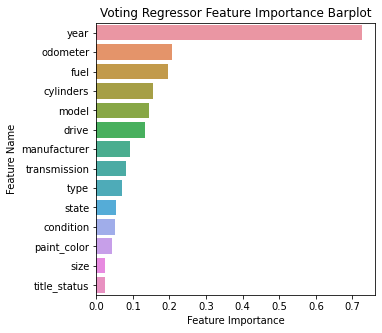

In [ ]:
fig =  plt.figure(figsize = (5,5))
#Plot Searborn bar chart
sns.barplot(x = 'Feature Importance', y = 'Feature', data = voting_df, order = voting_df.sort_values('Feature Importance', ascending=False)['Feature'])
#Add chart labels
plt.title('Voting Regressor Feature Importance Barplot')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show();
plt.close()


## Ada Boost

In [ ]:
Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [14995 47900 11500 32500  1750]
ytrain =  [17117.04887152 42913.10713838 17117.04887152 29584.89724831
 10292.51117528]
acc(r2_score) for training =  43.9
acc(relative error) for training = 43.8
acc(rmse) for training = 1077838.56
target_test = [24995  5995 14990 36900  6900]
ytest = [29584.89724831 17117.04887152 17897.58114354 29066.60342581
 17622.44643122]
acc(r2_score) for test = 44.4
acc(relative error) for test = 43.73
acc(rmse) for test = 1075313.03


## Model Comparison

In [ ]:
models = pd.DataFrame({
    'Model': ['LinearRegression', 'LinearSVR', 'SVR', 
              'MLPRegressor', 'SGDRegressor', 
              'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor', 'LGBM',
              'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'VotingRegressor', 'AdaBoostRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [ ]:
models.to_csv('tables.csv', index = False)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
12,VotingRegressor,99.53,89.05,2.38,11.32,"99,122.26","477,102.04"
11,ExtraTreesRegressor,99.95,88.64,0.10,11.00,"31,906.03","486,110.48"
6,RandomForestRegressor,98.25,88.06,4.65,12.26,"190,284.72","498,388.17"
8,LGBM,89.63,87.23,14.66,15.75,"463,434.90","515,252.40"
10,BaggingRegressor,97.50,86.67,5.37,13.23,"227,531.48","526,536.49"
7,XGBRegressor,84.89,83.23,18.04,18.73,"559,385.20","590,597.46"
5,DecisionTreeRegressor,99.95,77.10,0.10,15.25,"31,904.89","690,106.74"
3,MLPRegressor,65.65,65.91,29.54,29.49,"843,329.12","842,036.17"
13,AdaBoostRegressor,43.90,44.40,43.80,43.73,"1,077,838.56","1,075,313.03"
0,LinearRegression,28.83,29.46,47.34,47.22,"1,213,935.09","1,211,198.61"


In [ ]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
11,ExtraTreesRegressor,99.95,88.64,0.10,11.00,"31,906.03","486,110.48"
12,VotingRegressor,99.53,89.05,2.38,11.32,"99,122.26","477,102.04"
6,RandomForestRegressor,98.25,88.06,4.65,12.26,"190,284.72","498,388.17"
10,BaggingRegressor,97.50,86.67,5.37,13.23,"227,531.48","526,536.49"
5,DecisionTreeRegressor,99.95,77.10,0.10,15.25,"31,904.89","690,106.74"
8,LGBM,89.63,87.23,14.66,15.75,"463,434.90","515,252.40"
7,XGBRegressor,84.89,83.23,18.04,18.73,"559,385.20","590,597.46"
3,MLPRegressor,65.65,65.91,29.54,29.49,"843,329.12","842,036.17"
13,AdaBoostRegressor,43.90,44.40,43.80,43.73,"1,077,838.56","1,075,313.03"
2,SVR,10.52,14.21,44.35,44.11,"1,361,232.90","1,335,716.13"


In [ ]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
12,VotingRegressor,99.53,89.05,2.38,11.32,"99,122.26","477,102.04"
11,ExtraTreesRegressor,99.95,88.64,0.10,11.00,"31,906.03","486,110.48"
6,RandomForestRegressor,98.25,88.06,4.65,12.26,"190,284.72","498,388.17"
8,LGBM,89.63,87.23,14.66,15.75,"463,434.90","515,252.40"
10,BaggingRegressor,97.50,86.67,5.37,13.23,"227,531.48","526,536.49"
7,XGBRegressor,84.89,83.23,18.04,18.73,"559,385.20","590,597.46"
5,DecisionTreeRegressor,99.95,77.10,0.10,15.25,"31,904.89","690,106.74"
3,MLPRegressor,65.65,65.91,29.54,29.49,"843,329.12","842,036.17"
13,AdaBoostRegressor,43.90,44.40,43.80,43.73,"1,077,838.56","1,075,313.03"
0,LinearRegression,28.83,29.46,47.34,47.22,"1,213,935.09","1,211,198.61"


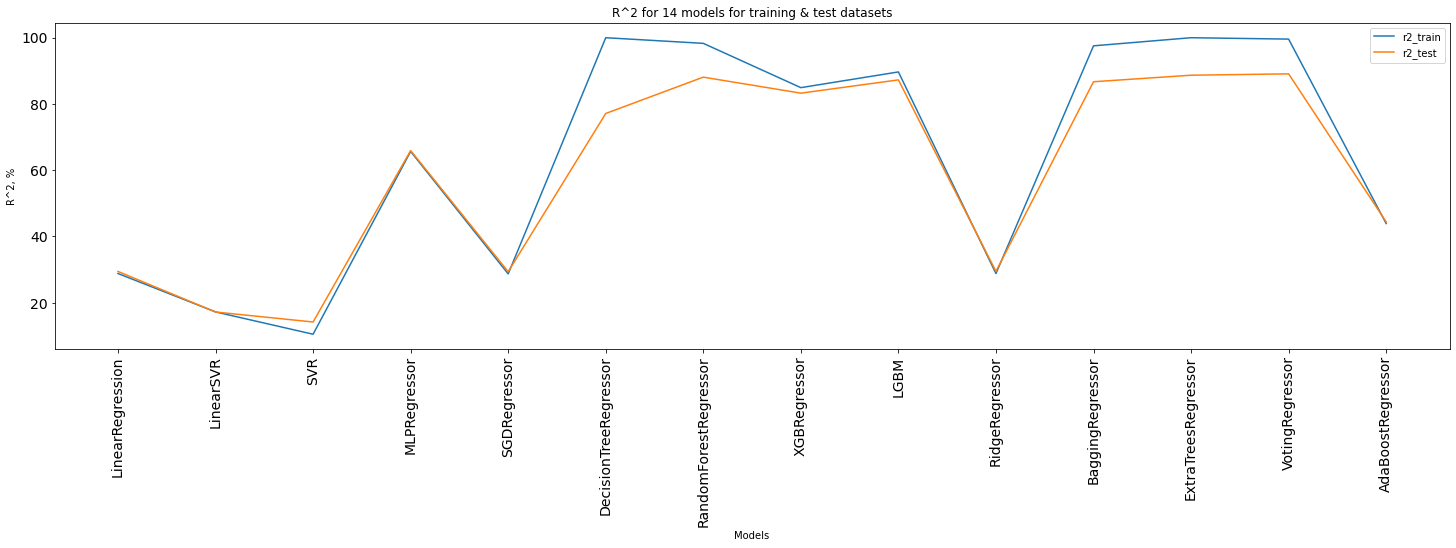

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R^2 for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('R^2, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

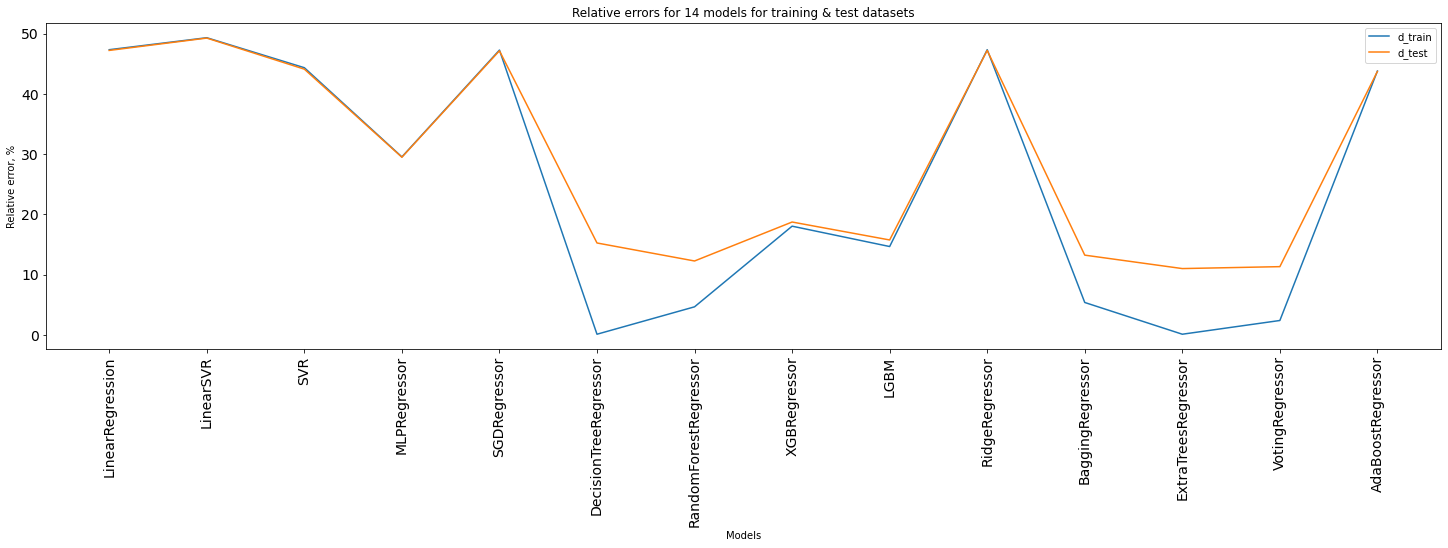

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

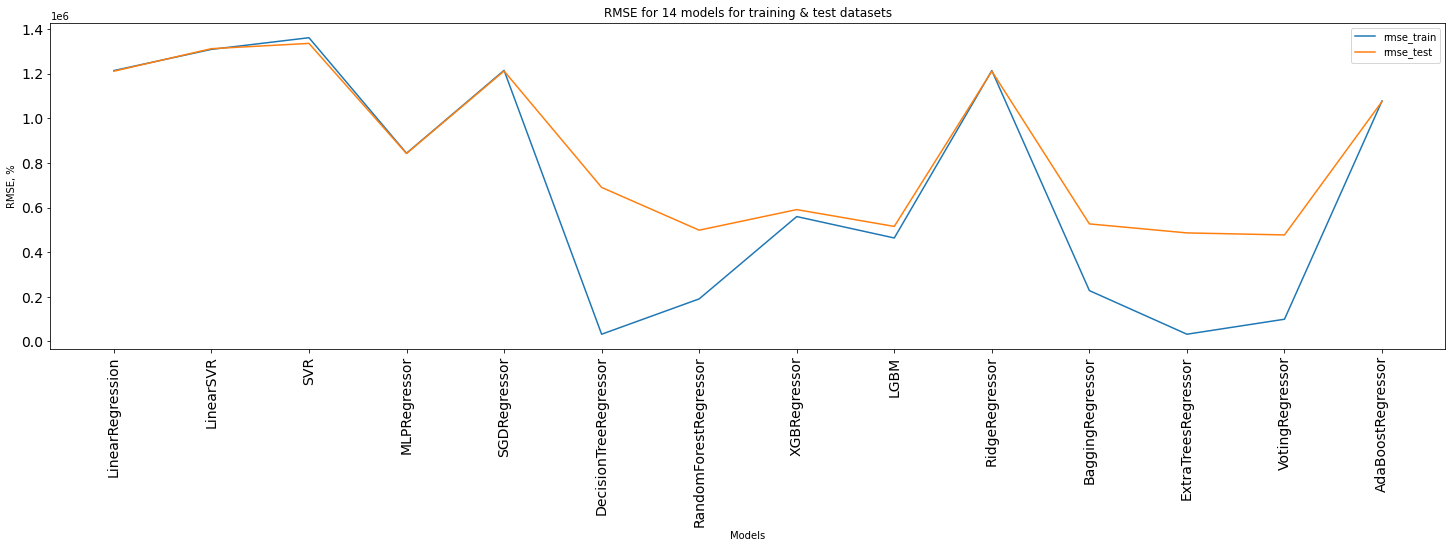

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 14 models for training & test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

# Prediction

In [ ]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76848 entries, 321002 to 271055
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          76848 non-null  float64
 1   manufacturer  76848 non-null  int64  
 2   model         76848 non-null  int64  
 3   condition     76848 non-null  int64  
 4   cylinders     76848 non-null  int64  
 5   fuel          76848 non-null  int64  
 6   odometer      76848 non-null  int64  
 7   title_status  76848 non-null  int64  
 8   transmission  76848 non-null  int64  
 9   drive         76848 non-null  int64  
 10  size          76848 non-null  int64  
 11  type          76848 non-null  int64  
 12  paint_color   76848 non-null  int64  
 13  state         76848 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 8.8 MB


In [ ]:
test0.head(3)

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
321002,"2,006.00",4,28932,4,7,2,146103,0,0,2,3,0,0,37
170559,"2,018.00",3,7663,2,7,2,13035,0,3,1,3,10,6,17
211245,"2,018.00",13,13017,4,3,2,46275,0,0,0,3,0,5,23


In [ ]:
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [ ]:
lin_reg.fit(train0, train_target0)
lin_reg.predict(testn)[:3]

array([15887.78217742, 34436.85011676, 18968.47754935])

In [ ]:
ridge.fit(train0, train_target0)
ridge.predict(testn)[:3]

array([15887.89428218, 34436.3911515 , 18968.5199704 ])